In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import netCDF4
import statsmodels.tsa.stattools as tools
import scipy
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from dateutil import rrule
from datetime import datetime, timedelta
import pandas as pd
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!
import seaborn as sns  # for better style in plots
from eofs.standard import Eof
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xarray as xr

In [2]:
sst = xr.open_dataset('/data/um/sst/hadisst_sst_mon_mean.nc', decode_times=True, autoclose=True, decode_coords=True)

In [3]:
#calculate nino 3.4 index
sst_tp         = sst.sel(time=slice('1895','2018'),longitude=slice(-170,-120),latitude=slice(5,-5))
tp_mn_climo    = sst_tp.sel(time=slice('1950','1979')).groupby(sst_tp.time.sel(time=slice('1950','1979')).dt.month).mean()
nino34         = sst_tp.sst.mean(axis=(1,2)) - np.tile(tp_mn_climo.sst.values, 2019-1895)
inds           = pd.DataFrame(data=nino34.values, index=nino34.time.values, columns=['nino34'])
inds['nino34'] = inds['nino34'].rolling(5, win_type='triang', center=True).mean()

In [4]:
#calculate amo index
sst_na       = sst.sel(time=slice('1895','2018'),longitude=slice(-80,0),latitude=slice(65,0))
sst_na_anom  = np.ma.masked_where(np.ma.masked_invalid(sst_na.sst.values) == -1000.0, np.ma.masked_invalid(sst_na.sst.values)).anom(axis=0)
na_am        = np.ma.average(np.ma.average(sst_na_anom, axis=1, weights=np.sort(sst_na.latitude.values)), axis=1)
na_am_linfit = np.polyfit(np.arange(na_am.shape[0]), na_am, deg=1)
na_am_lin    = na_am_linfit[0]*np.arange(na_am.shape[0])
na_am        = na_am - na_am_lin
buffer       = pd.DataFrame(data=na_am, index=sst_na.time, columns=['na_am'])
na_mn_climo  = buffer['na_am'].groupby(buffer['na_am'].index.month).mean()
amo          = na_am - np.tile(na_mn_climo.values, 2019-1895)
inds['amo']  = amo
inds['amo']  = inds['amo'].rolling(120, win_type='triang', center=True).mean()

In [5]:
#calculate pdo index
lon_np                       = np.roll(sst.longitude.values, 180)
lon_np[np.where(lon_np < 0)] = lon_np[np.where(lon_np < 0)] + 360
lon_np                       = lon_np[120:260]

sst_np = sst.sst.sel(time=slice('1895','2018'),latitude=slice(65,20)).values
sst_np = np.roll(sst_np, 180, axis=2)
sst_np = np.ma.masked_invalid(np.ma.masked_where(sst_np[:,:,120:260] == -1000.0, sst_np[:,:,120:260]))

time_np = sst.time.sel(time=slice('1895','2018')).values

for i in np.arange(sst_np.shape[1]):
    for j in np.arange(sst_np.shape[2]):
        if (np.any(np.isfinite(sst_np[:,i,j]))):
            np_poly       = np.polyfit(np.arange(sst_np.shape[0]), sst_np[:,i,j], deg=1)
            np_linfit     = np_poly[0]*np.arange(sst_np.shape[0])
            sst_np[:,i,j] = sst_np[:,i,j] - np_linfit
        
        buffer        = pd.DataFrame(data=sst_np[:,i,j], index=time_np)
        mn_sc         = buffer.groupby(buffer.index.month).mean()
        tile_mn_sc    = np.tile(mn_sc.T, 2019-1895)
        sst_np[:,i,j] = sst_np[:,i,j] - tile_mn_sc

solver      = Eof(sst_np, weights=np.cos(np.deg2rad(sst.latitude.sel(latitude=slice(65,20)).values))[...,np.newaxis])
np_eof      = -solver.eofs(neofs=1)
inds['pdo'] = -solver.pcs(npcs=1, pcscaling=0)

inds['pdo'] = inds['pdo']/np.std(inds['pdo'])
inds['pdo'] = inds['pdo'].rolling(120, center=True, win_type='triang').mean()


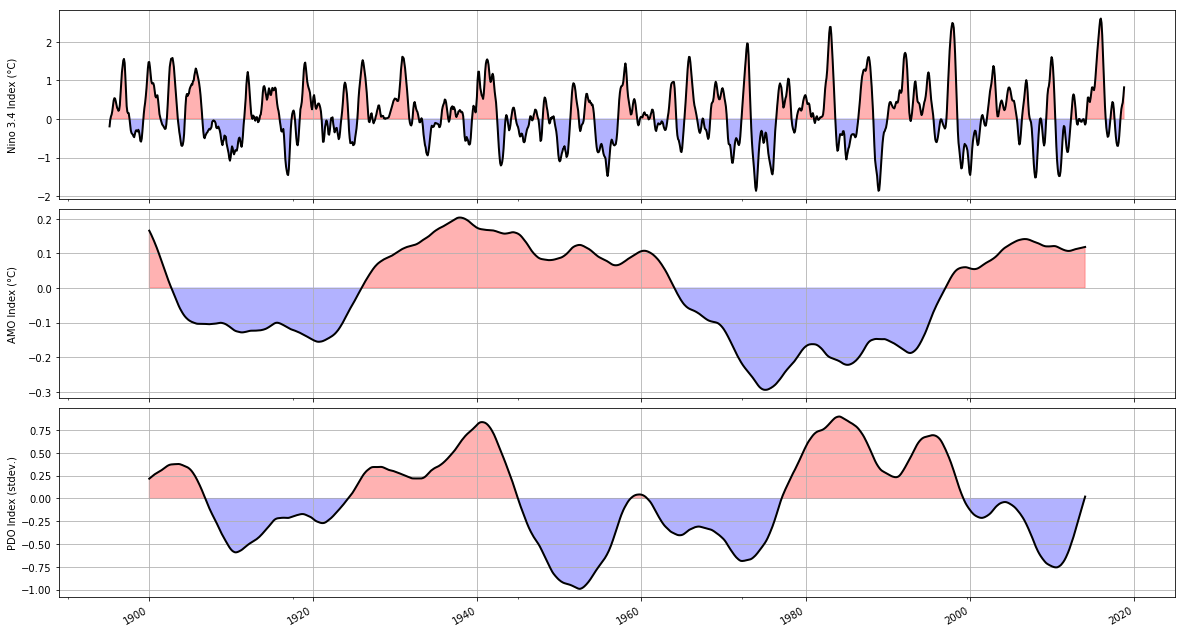

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,12), sharex=True)
plt.subplots_adjust(hspace=0.05)

inds['nino34'].plot(ax=ax[0], color='black', linewidth=2)
ax[0].fill_between(inds.index, np.where(inds['nino34'] > 0, inds['nino34'], np.nan), 0, color='red', alpha=.3)
ax[0].fill_between(inds.index, np.where(inds['nino34'] < 0, inds['nino34'], np.nan), 0, color='blue', alpha=.3)
inds['amo'].plot(ax=ax[1], color='black', linewidth=2)
ax[1].fill_between(inds.index, np.where(inds['amo'] > 0, inds['amo'], np.nan), 0, color='red', alpha=.3)
ax[1].fill_between(inds.index, np.where(inds['amo'] < 0, inds['amo'], np.nan), 0, color='blue', alpha=.3)
inds['pdo'].plot(ax=ax[2], color='black', linewidth=2)
ax[2].fill_between(inds.index, np.where(inds['pdo'] > 0, inds['pdo'], np.nan), 0, color='red', alpha=.3)
ax[2].fill_between(inds.index, np.where(inds['pdo'] < 0, inds['pdo'], np.nan), 0, color='blue', alpha=.3)

ax[0].set_ylabel('Nino 3.4 Index (°C)')
ax[1].set_ylabel('AMO Index (°C)')
ax[2].set_ylabel('PDO Index (stdev.)')

ax[0].grid()
ax[1].grid()
ax[2].grid()

fig.align_ylabels(ax)

plt.savefig('/Users/tfenske/Documents/school/miami-grad/fall2019/atm768/hw2/figures/time_series.png')

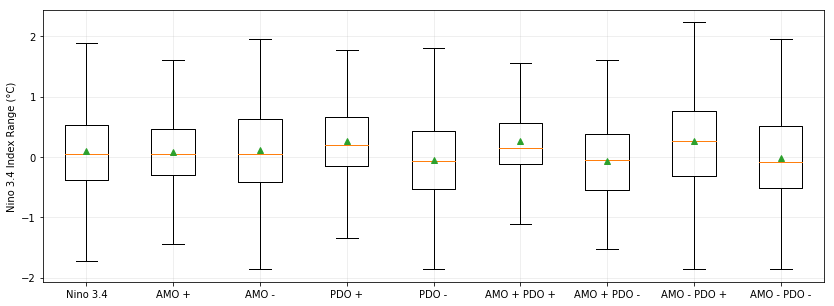

In [8]:
amo    =    inds['amo'].values[~np.isnan(inds['amo'].values)]
pdo    =    inds['pdo'].values[~np.isnan(inds['pdo'].values)]
nino34 = inds['nino34'].values[~np.isnan(inds['amo'].values)]

amop     = nino34[(amo > 0)]
amon     = nino34[(amo < 0)]
pdop     = nino34[(pdo > 0)]
pdon     = nino34[(pdo < 0)]
amoppdop = nino34[(amo > 0) & (pdo > 0)]
amoppdon = nino34[(amo > 0) & (pdo < 0)]
amonpdop = nino34[(amo < 0) & (pdo > 0)]
amonpdon = nino34[(amo < 0) & (pdo < 0)]

labels = ['Nino 3.4', 
          'AMO +', 'AMO -', 
          'PDO +', 'PDO -', 
          'AMO + PDO +', 'AMO + PDO -', 
          'AMO - PDO +', 'AMO - PDO -']

nino34_case_amps = (nino34, amop, amon, pdop, pdon, amoppdop, amoppdon, amonpdop, amonpdon)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5))

ax.boxplot(nino34_case_amps, showfliers=False, showmeans=True, labels=labels)
ax.grid(alpha=.25)
ax.set_ylabel('Nino 3.4 Index Range (°C)')

plt.savefig('/Users/tfenske/Documents/school/miami-grad/fall2019/atm768/hw2/figures/amplitudes.png')

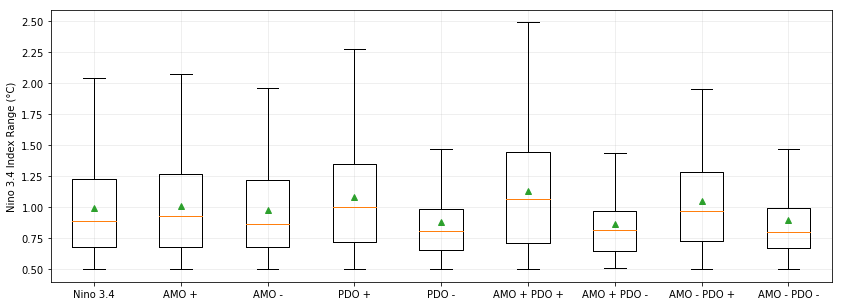

In [23]:
amo    =    inds['amo'].values[~np.isnan(inds['amo'].values)]
pdo    =    inds['pdo'].values[~np.isnan(inds['pdo'].values)]
nino34 = inds['nino34'].values[~np.isnan(inds['amo'].values)]

amop     = nino34[(amo > 0) & (nino34 > .5)]
amon     = nino34[(amo < 0) & (nino34 > .5)]
pdop     = nino34[(pdo > 0) & (nino34 > .5)]
pdon     = nino34[(pdo < 0) & (nino34 > .5)]
amoppdop = nino34[(amo > 0) & (pdo > 0) & (nino34 > .5)]
amoppdon = nino34[(amo > 0) & (pdo < 0) & (nino34 > .5)]
amonpdop = nino34[(amo < 0) & (pdo > 0) & (nino34 > .5)]
amonpdon = nino34[(amo < 0) & (pdo < 0) & (nino34 > .5)]

labels = ['Nino 3.4', 
          'AMO +', 'AMO -', 
          'PDO +', 'PDO -', 
          'AMO + PDO +', 'AMO + PDO -', 
          'AMO - PDO +', 'AMO - PDO -']

nino34_case_amps = (nino34[(nino34 > .5)], amop, amon, pdop, pdon, amoppdop, amoppdon, amonpdop, amonpdon)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5))

ax.boxplot(nino34_case_amps, showfliers=False, showmeans=True, labels=labels)
ax.grid(alpha=.25)
ax.set_ylabel('Nino 3.4 Index Range (°C)')

plt.savefig('/Users/tfenske/Documents/school/miami-grad/fall2019/atm768/hw2/figures/amplitudes_en_only.png')

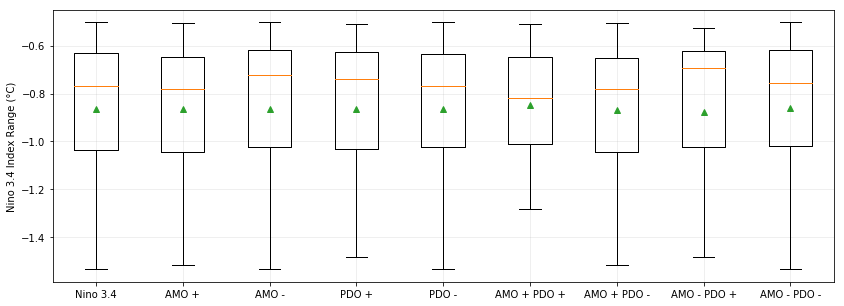

In [26]:
amo    =    inds['amo'].values[~np.isnan(inds['amo'].values)]
pdo    =    inds['pdo'].values[~np.isnan(inds['pdo'].values)]
nino34 = inds['nino34'].values[~np.isnan(inds['amo'].values)]

amop     = nino34[(amo > 0) & (nino34 < -.5)]
amon     = nino34[(amo < 0) & (nino34 < -.5)]
pdop     = nino34[(pdo > 0) & (nino34 < -.5)]
pdon     = nino34[(pdo < 0) & (nino34 < -.5)]
amoppdop = nino34[(amo > 0) & (pdo > 0) & (nino34 < -.5)]
amoppdon = nino34[(amo > 0) & (pdo < 0) & (nino34 < -.5)]
amonpdop = nino34[(amo < 0) & (pdo > 0) & (nino34 < -.5)]
amonpdon = nino34[(amo < 0) & (pdo < 0) & (nino34 < -.5)]

labels = ['Nino 3.4', 
          'AMO +', 'AMO -', 
          'PDO +', 'PDO -', 
          'AMO + PDO +', 'AMO + PDO -', 
          'AMO - PDO +', 'AMO - PDO -']

nino34_case_amps = (nino34[(nino34 < -.5)], amop, amon, pdop, pdon, amoppdop, amoppdon, amonpdop, amonpdon)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5))

ax.boxplot(nino34_case_amps, showfliers=False, showmeans=True, labels=labels)
ax.grid(alpha=.25)
ax.set_ylabel('Nino 3.4 Index Range (°C)')

plt.savefig('/Users/tfenske/Documents/school/miami-grad/fall2019/atm768/hw2/figures/amplitudes_ln_only.png')

In [9]:
amo    =    inds['amo'].values[~np.isnan(inds['amo'].values)]
pdo    =    inds['pdo'].values[~np.isnan(inds['pdo'].values)]
nino34 = inds['nino34'].values[~np.isnan(inds['amo'].values)]

amop     = nino34[(amo > 0)]
amon     = nino34[(amo < 0)]
pdop     = nino34[(pdo > 0)]
pdon     = nino34[(pdo < 0)]
amoppdop = nino34[(amo > 0) & (pdo > 0)]
amoppdon = nino34[(amo > 0) & (pdo < 0)]
amonpdop = nino34[(amo < 0) & (pdo > 0)]
amonpdon = nino34[(amo < 0) & (pdo < 0)]

en,          ln          = nino34[(nino34 > .5)], nino34[(nino34 < -.5)]
en_amop,     ln_amop     = amop[(amop > .5)], amop[(amop < -.5)]
en_amon,     ln_amon     = amon[(amon > .5)], amon[(amon < -.5)]
en_pdop,     ln_pdop     = pdop[(pdop > .5)], pdop[(pdop < -.5)]
en_pdon,     ln_pdon     = pdon[(pdon > .5)], pdon[(pdon < -.5)]
en_amoppdop, ln_amoppdop = amoppdop[(amoppdop > .5)], amoppdop[(amoppdop < -.5)]
en_amoppdon, ln_amoppdon = amoppdon[(amoppdon > .5)], amoppdon[(amoppdon < -.5)]
en_amonpdop, ln_amonpdop = amonpdop[(amonpdop > .5)], amonpdop[(amonpdop < -.5)]
en_amonpdon, ln_amonpdon = amonpdon[(amonpdon > .5)], amonpdon[(amonpdon < -.5)]

en_freq,          ln_freq          = float(np.size(en))/float(np.size(nino34)), -float(np.size(ln))/float(np.size(nino34)), 
en_amop_freq,     ln_amop_freq     = float(np.size(en_amop))/float(np.size(amop)), -float(np.size(ln_amop))/float(np.size(amop))
en_amon_freq,     ln_amon_freq     = float(np.size(en_amon))/float(np.size(amon)), -float(np.size(ln_amon))/float(np.size(amon))
en_pdop_freq,     ln_pdop_freq     = float(np.size(en_pdop))/float(np.size(pdop)), -float(np.size(ln_pdop))/float(np.size(pdop))
en_pdon_freq,     ln_pdon_freq     = float(np.size(en_pdon))/float(np.size(pdon)), -float(np.size(ln_pdon))/float(np.size(pdon))
en_amoppdop_freq, ln_amoppdop_freq = float(np.size(en_amoppdop))/float(np.size(amoppdop)), -float(np.size(ln_amoppdop))/float(np.size(amoppdop))
en_amoppdon_freq, ln_amoppdon_freq = float(np.size(en_amoppdon))/float(np.size(amoppdon)), -float(np.size(ln_amoppdon))/float(np.size(amoppdon))
en_amonpdop_freq, ln_amonpdop_freq = float(np.size(en_amonpdop))/float(np.size(amonpdop)), -float(np.size(ln_amonpdop))/float(np.size(amonpdop))
en_amonpdon_freq, ln_amonpdon_freq = float(np.size(en_amonpdon))/float(np.size(amonpdon)), -float(np.size(ln_amonpdon))/float(np.size(amonpdon))

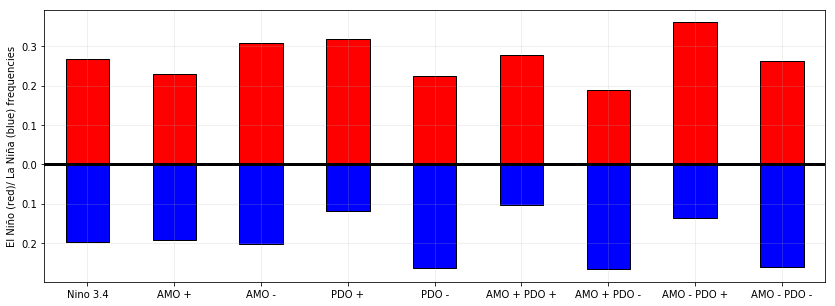

In [21]:
en_freqs = [en_freq, 
            en_amop_freq, en_amon_freq,
            en_pdop_freq, en_pdon_freq, 
            en_amoppdop_freq, en_amoppdon_freq,
            en_amonpdop_freq, en_amonpdon_freq]

ln_freqs = [ln_freq, 
            ln_amop_freq, ln_amon_freq,
            ln_pdop_freq, ln_pdon_freq, 
            ln_amoppdop_freq, ln_amoppdon_freq,
            ln_amonpdop_freq, ln_amonpdon_freq]

labels = ['Nino 3.4', 
          'AMO +', 'AMO -', 
          'PDO +', 'PDO -', 
          'AMO + PDO +', 'AMO + PDO -', 
          'AMO - PDO +', 'AMO - PDO -']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5))

ax.bar(np.arange(9), en_freqs, color='red', edgecolor='black', width=.5)
ax.bar(np.arange(9), ln_freqs, color='blue', edgecolor='black', width=.5)
ax.set_xticks(np.arange(9))
ax.set_xticklabels(labels)
ax.set_yticks(np.linspace(-.4, .4, 9))
ax.set_yticklabels(['0.4', '0.3', '0.2', '0.1', '0.0', '0.1', '0.2', '0.3', '0.4'])
ax.grid(alpha=.25)
ax.set_ylabel('El Niño (red)/ La Niña (blue) frequencies')
ax.plot(np.linspace(-1,9,11), np.zeros(11), linewidth=3, color='black')
ax.set_xlim([-.5,8.5])

plt.savefig('/Users/tfenske/Documents/school/miami-grad/fall2019/atm768/hw2/figures/frequencies.png')

In [213]:
amo    =    inds['amo'].values[~np.isnan(inds['amo'].values)]
pdo    =    inds['pdo'].values[~np.isnan(inds['pdo'].values)]
nino34 = inds['nino34'].values[~np.isnan(inds['amo'].values)]
times  = inds.index[~np.isnan(inds['amo'].values)]

t_en          = times[(nino34 > 0.5)]
t_en_amop     = times[(nino34 > 0.5) & (amo > 0)]
t_en_amon     = times[(nino34 > 0.5) & (amo < 0)]
t_en_pdop     = times[(nino34 > 0.5) & (pdo > 0)]
t_en_pdon     = times[(nino34 > 0.5) & (pdo < 0)]
t_en_amoppdop = times[(nino34 > 0.5) & (amo > 0) & (pdo > 0)]
t_en_amoppdon = times[(nino34 > 0.5) & (amo > 0) & (pdo < 0)]
t_en_amonpdop = times[(nino34 > 0.5) & (amo < 0) & (pdo > 0)]
t_en_amonpdon = times[(nino34 > 0.5) & (amo < 0) & (pdo < 0)]

t_ln          = times[(nino34 < -0.5)]
t_ln_amop     = times[(nino34 < -0.5) & (amo > 0)]
t_ln_amon     = times[(nino34 < -0.5) & (amo < 0)]
t_ln_pdop     = times[(nino34 < -0.5) & (pdo > 0)]
t_ln_pdon     = times[(nino34 < -0.5) & (pdo < 0)]
t_ln_amoppdop = times[(nino34 < -0.5) & (amo > 0) & (pdo > 0)]
t_ln_amoppdon = times[(nino34 < -0.5) & (amo > 0) & (pdo < 0)]
t_ln_amonpdop = times[(nino34 < -0.5) & (amo < 0) & (pdo > 0)]
t_ln_amonpdon = times[(nino34 < -0.5) & (amo < 0) & (pdo < 0)]

In [240]:
lon_roll                         = np.roll(sst.longitude.values, 180)
lon_roll[np.where(lon_roll < 0)] = lon_roll[np.where(lon_roll < 0)] + 360
sst['longitude'] = (('longitude'), lon_roll)

sst_buffer  = np.ma.masked_invalid(sst.sst.values)
sst_buffer  = np.ma.masked_where(sst_buffer == -1000., sst_buffer)
sst_anom    = np.roll(sst_buffer.anom(axis=0), 180, axis=2)
sst['anom'] = (('time', 'latitude', 'longitude'), sst_anom)


In [241]:
en_ss          = sst.anom.sel(time=t_en         ).mean(axis=0, skipna=True)
en_amop_ss     = sst.anom.sel(time=t_en_amop    ).mean(axis=0, skipna=True)
en_amon_ss     = sst.anom.sel(time=t_en_amon    ).mean(axis=0, skipna=True)
en_pdop_ss     = sst.anom.sel(time=t_en_pdop    ).mean(axis=0, skipna=True)
en_pdon_ss     = sst.anom.sel(time=t_en_pdon    ).mean(axis=0, skipna=True)
en_amoppdop_ss = sst.anom.sel(time=t_en_amoppdop).mean(axis=0, skipna=True)
en_amoppdon_ss = sst.anom.sel(time=t_en_amoppdon).mean(axis=0, skipna=True)
en_amonpdop_ss = sst.anom.sel(time=t_en_amonpdop).mean(axis=0, skipna=True)
en_amonpdon_ss = sst.anom.sel(time=t_en_amonpdon).mean(axis=0, skipna=True)

ln_ss          = sst.anom.sel(time=t_ln         ).mean(axis=0, skipna=True)
ln_amop_ss     = sst.anom.sel(time=t_ln_amop    ).mean(axis=0, skipna=True)
ln_amon_ss     = sst.anom.sel(time=t_ln_amon    ).mean(axis=0, skipna=True)
ln_pdop_ss     = sst.anom.sel(time=t_ln_pdop    ).mean(axis=0, skipna=True)
ln_pdon_ss     = sst.anom.sel(time=t_ln_pdon    ).mean(axis=0, skipna=True)
ln_amoppdop_ss = sst.anom.sel(time=t_ln_amoppdop).mean(axis=0, skipna=True)
ln_amoppdon_ss = sst.anom.sel(time=t_ln_amoppdon).mean(axis=0, skipna=True)
ln_amonpdop_ss = sst.anom.sel(time=t_ln_amonpdop).mean(axis=0, skipna=True)
ln_amonpdon_ss = sst.anom.sel(time=t_ln_amonpdon).mean(axis=0, skipna=True)


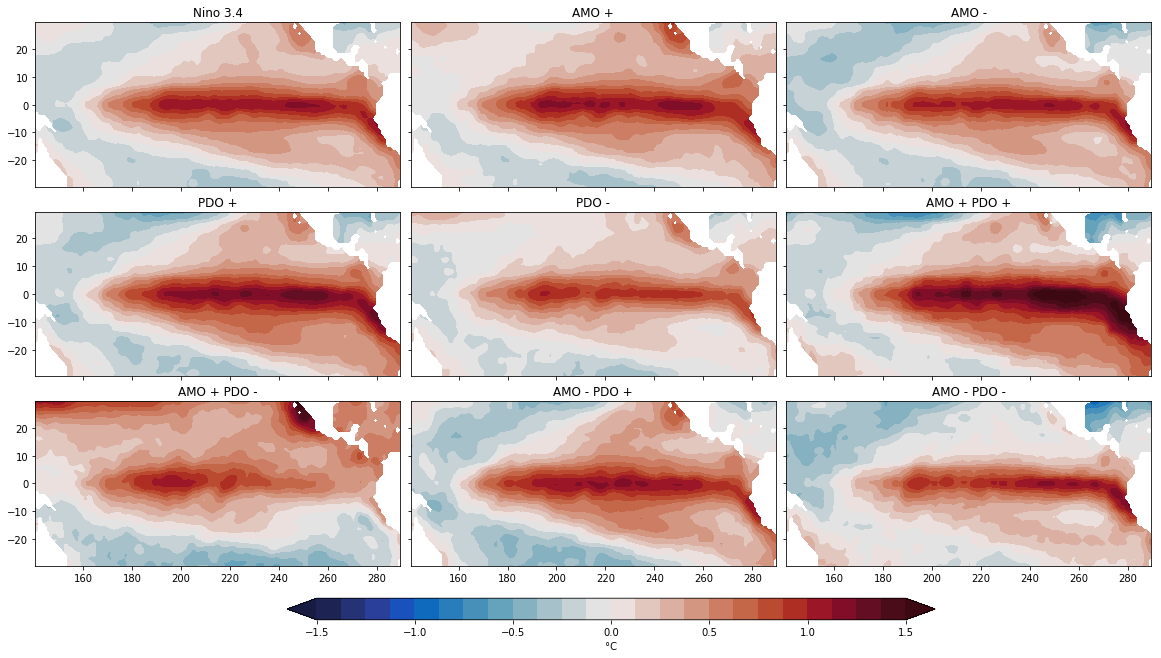

In [306]:
en_sss = [en_ss, en_amop_ss, en_amon_ss, en_pdop_ss, en_pdon_ss, 
          en_amoppdop_ss, en_amoppdon_ss, en_amonpdop_ss, en_amonpdon_ss]

titles = ['Nino 3.4', 
          'AMO +', 'AMO -', 
          'PDO +', 'PDO -', 
          'AMO + PDO +', 'AMO + PDO -', 
          'AMO - PDO +', 'AMO - PDO -']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10), sharex=True, sharey=True)

for i in np.arange(3):
    for j in np.arange(3):
        n = i*3 + j
        
        lat = sst.latitude.sel(latitude=slice(30,-30))
        lon = sst.longitude.sel(longitude=slice(140,290))
        ss  = en_sss[n].sel(latitude=slice(30,-30), longitude=slice(140,290))
        
        cb = ax[i][j].contourf(lon, lat, ss, levels=np.linspace(-1.5,1.5,25), cmap=cmo.balance, extend='both')
        ax[i][j].set_title(titles[n])
        
cb_ax = fig.add_axes([0.3, 0.05, 0.45, 0.03])
cbar = fig.colorbar(cb, orientation='horizontal', shrink=.75, cax=cb_ax)
cbar.set_label('°C')
cbar.set_ticks(np.linspace(-1.5,1.5,7))

plt.subplots_adjust(wspace = 0.03, hspace = 0.15)
plt.savefig('/Users/tfenske/Documents/school/miami-grad/fall2019/atm768/hw2/figures/elnino_ss.png')

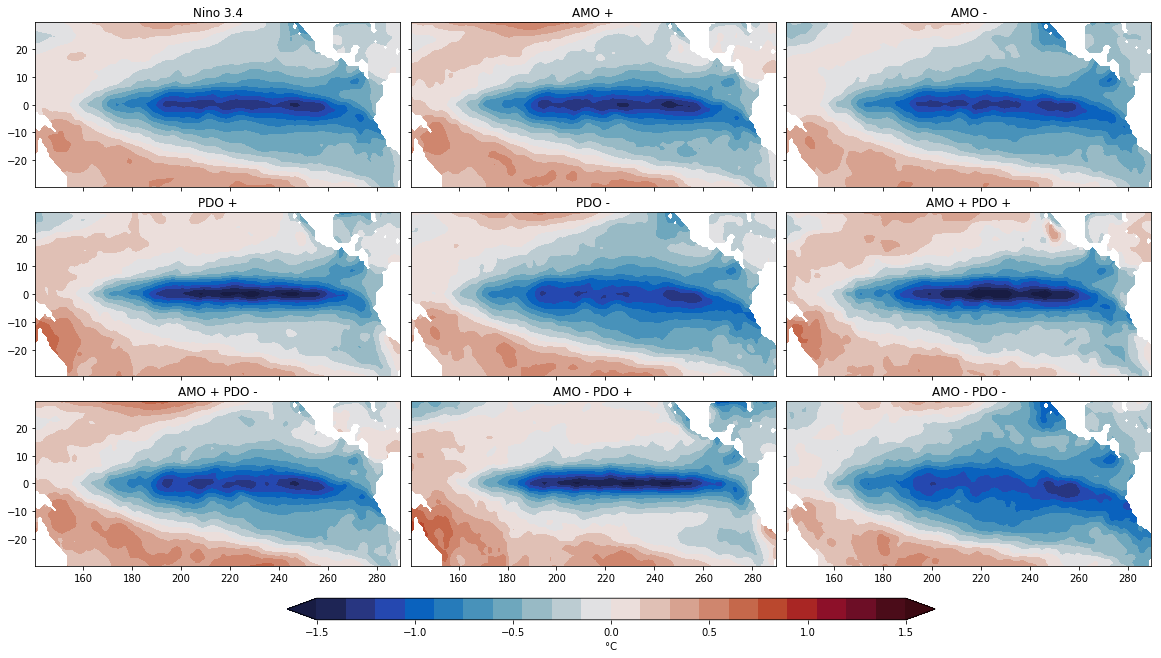

In [307]:
ln_sss = [ln_ss, ln_amop_ss, ln_amon_ss, ln_pdop_ss, ln_pdon_ss, 
          ln_amoppdop_ss, ln_amoppdon_ss, ln_amonpdop_ss, ln_amonpdon_ss]

titles = ['Nino 3.4', 
          'AMO +', 'AMO -', 
          'PDO +', 'PDO -', 
          'AMO + PDO +', 'AMO + PDO -', 
          'AMO - PDO +', 'AMO - PDO -']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10), sharex=True, sharey=True)

for i in np.arange(3):
    for j in np.arange(3):
        n = i*3 + j
        
        lat = sst.latitude.sel(latitude=slice(30,-30))
        lon = sst.longitude.sel(longitude=slice(140,290))
        ss  = ln_sss[n].sel(latitude=slice(30,-30), longitude=slice(140,290))
        
        cb = ax[i][j].contourf(lon, lat, ss, levels=np.linspace(-1.5,1.5,21), cmap=cmo.balance, extend='both')
        ax[i][j].set_title(titles[n])
        
cb_ax = fig.add_axes([0.3, 0.05, 0.45, 0.03])
cbar = fig.colorbar(cb, orientation='horizontal', shrink=.75, cax=cb_ax)
cbar.set_label('°C')
cbar.set_ticks(np.linspace(-1.5,1.5,7))

plt.subplots_adjust(wspace = 0.03, hspace = 0.15)
plt.savefig('/Users/tfenske/Documents/school/miami-grad/fall2019/atm768/hw2/figures/lanina_ss.png')